In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import os
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)


def load_csv(fname,verbose=True):
    if verbose:
        with open(fname) as f:
            print(f.readline().strip('\n'))
    return np.loadtxt(fname,skiprows=1,delimiter=",")

def plot_energy(fpath,csv1,save=False):
    fig,ax1 = plt.subplots()
    ax1.set_title(simlist[0])
    ax1.plot(csv1[:,0],csv1[:,1],label="TotalEnergy")
    ax1.set_xlabel("timesteps")
    ax1.set_ylabel("Total Energy")
    ax1.tick_params(axis ='y', labelcolor="tab:blue")
    ax2  = ax1.twinx()
    ax2.plot(csv1[:,0],csv1[:,2],label="Eexcess",color="tab:orange")
    ax2.set_ylabel("Ent. Excess")
    ax2.tick_params(axis ='y', labelcolor = "tab:orange")
    plt.show()
    if save:
        fname = fpath[:-4]+"_energy.png"
        print(fname)
        fig.savefig(fname)
        
%matplotlib ipympl

In [111]:
# saving a plot of total energy vs. time and entatiomeric excess vs time
# TAKES A LONG TIME TO RUN!!!
"""
%%capture # for not showing plots
for csvfile  in csvfiles:
    csvdata = load_csv(csvfile,verbose=False)
    plot_energy(csvfile,csvdata,save=True)
"""

/tmp/ipykernel_32368/1635524813.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))


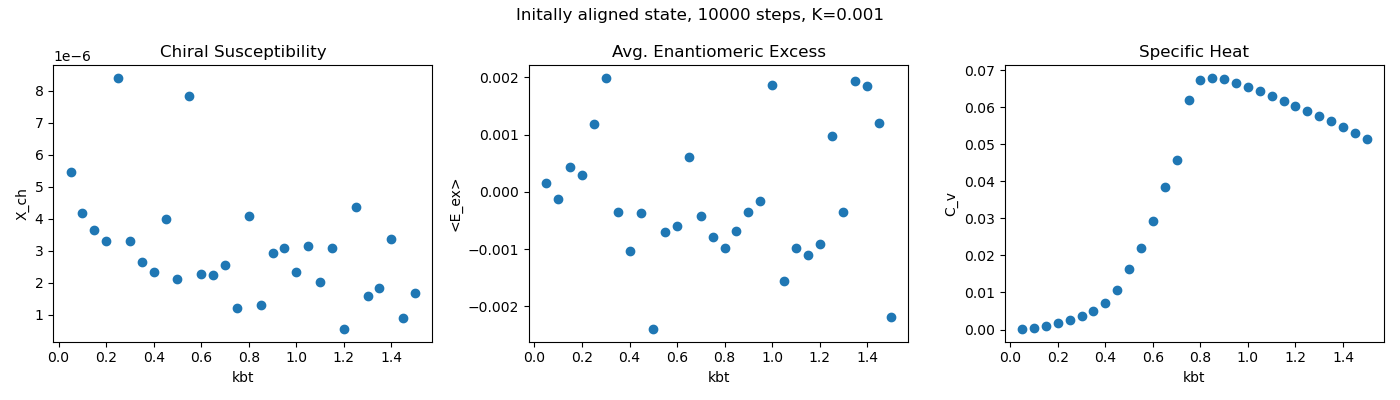

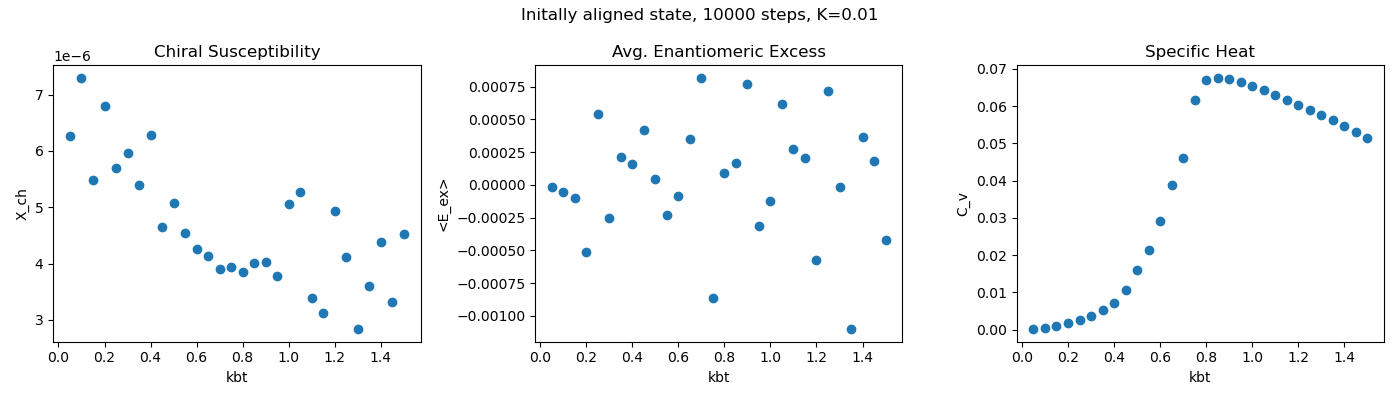

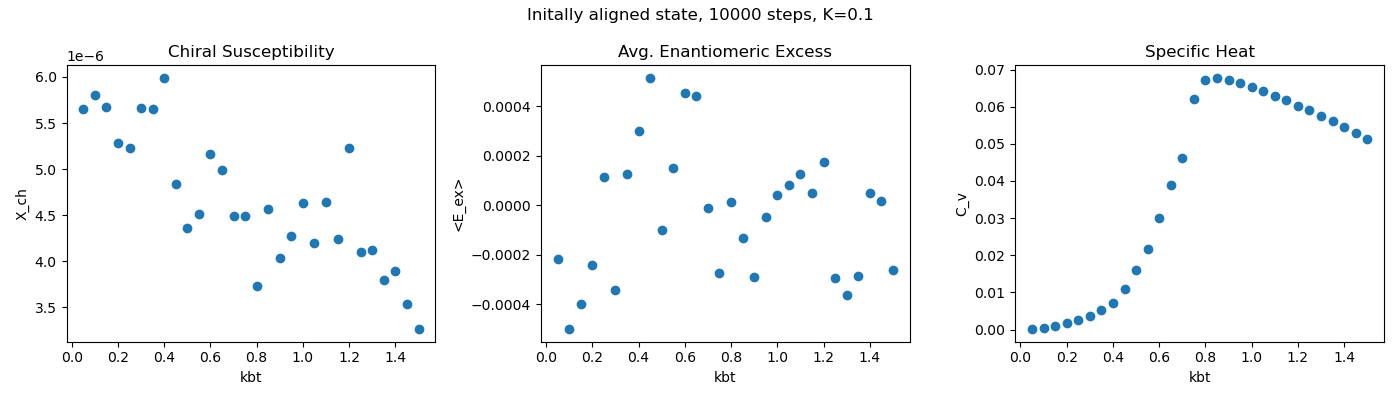

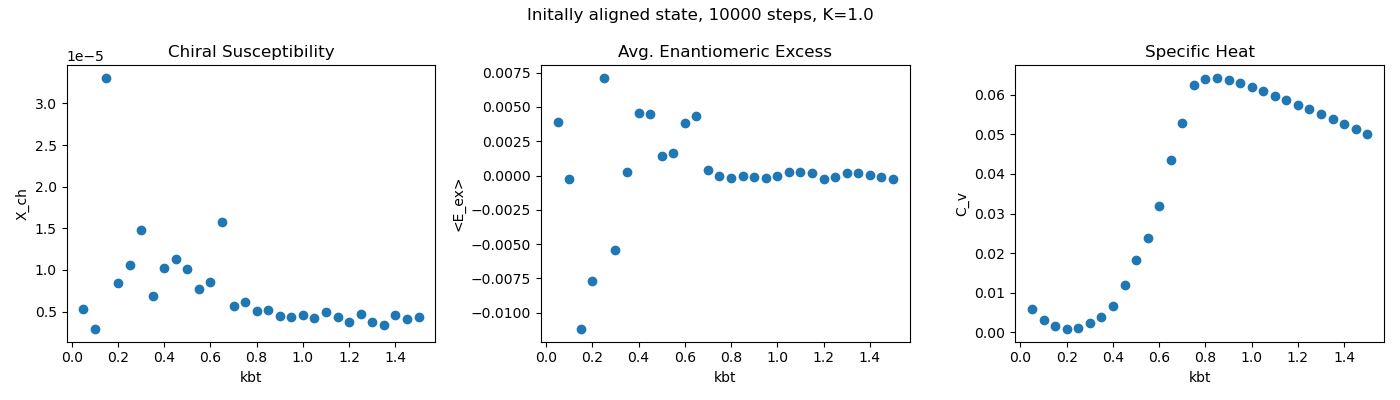

In [7]:
# measuring chiral susceptibility mean(enantionmeric excess^2) - mean(enantiomeric excess^2)
def measure_chi(Kin,init_type="aligned"):
    assert init_type == "aligned" or init_type == "random"
    ch_sus = []
    kbts = []
    avg_ent = []
    c_v = []
    for csvfile in csvfiles:
        csv1 = load_csv(csvfile,verbose=False)
        K = float(csvfile.split("/")[2].split("_")[-2][1:])
        if K == Kin and init_type in csvfile:
            kbt = float(csvfile.split("/")[2].split("_")[-1][3:])
            kbts.append(kbt)
            # chiral susceptibility
            excess = csv1[:,2]
            ch_sus.append(np.mean(excess**2) - np.mean(excess)**2)
            # average enantiomeric excess
            avg_ent.append(np.mean(excess))
            #specific heat
            E = csv1[:,1]
            c_v.append((np.mean(E**2) - np.mean(E)**2)/kbt)
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
    fig.suptitle("Initally aligned state, 10000 steps, K="+str(Kin))
    ax1.set_title("Chiral Susceptibility")
    ax1.set_ylabel("X_ch")
    ax1.set_xlabel("kbt")
    ax1.scatter(kbts,ch_sus)
    
    ax2.set_title("Avg. Enantiomeric Excess")
    ax2.set_ylabel("<E_ex>")
    ax2.set_xlabel("kbt")
    ax2.scatter(kbts,avg_ent)
    
    ax3.set_title("Specific Heat")
    ax3.set_ylabel("C_v")
    ax3.set_xlabel("kbt")
    ax3.scatter(kbts,c_v)
    fig.tight_layout()
    plt.show()

measure_chi(0.001)
measure_chi(0.01)
measure_chi(0.1)
measure_chi(1.0)

(30, 10)


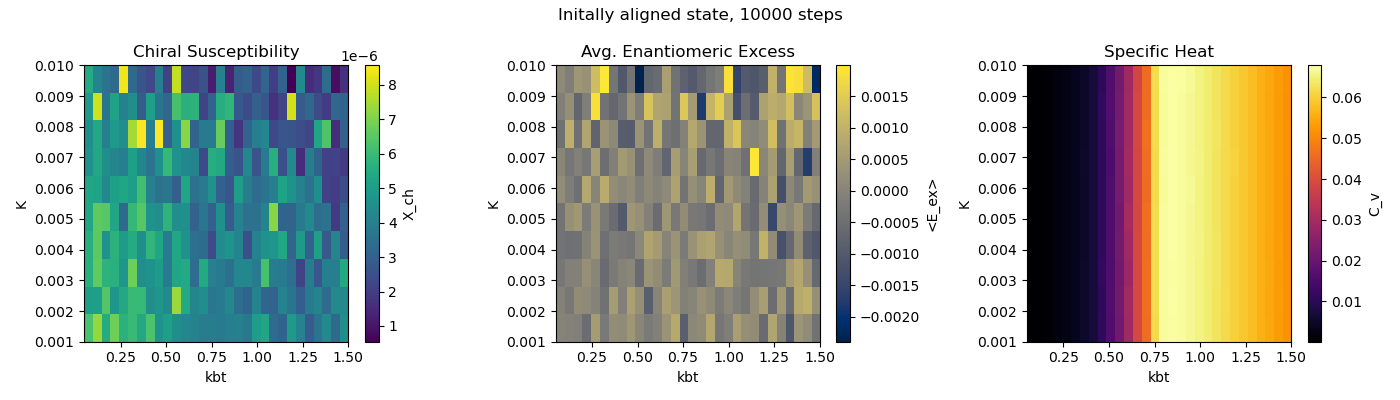

(30, 10)


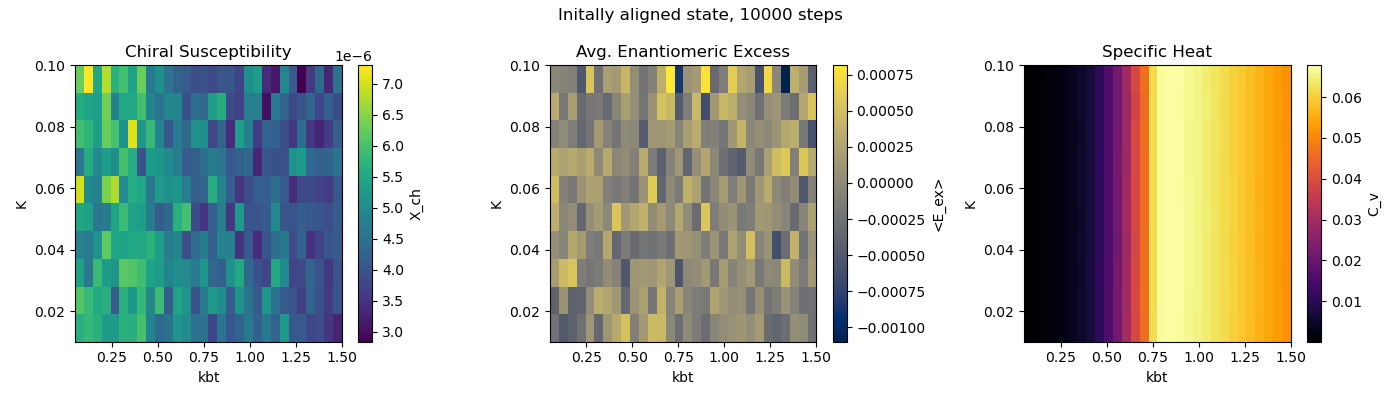

(30, 10)


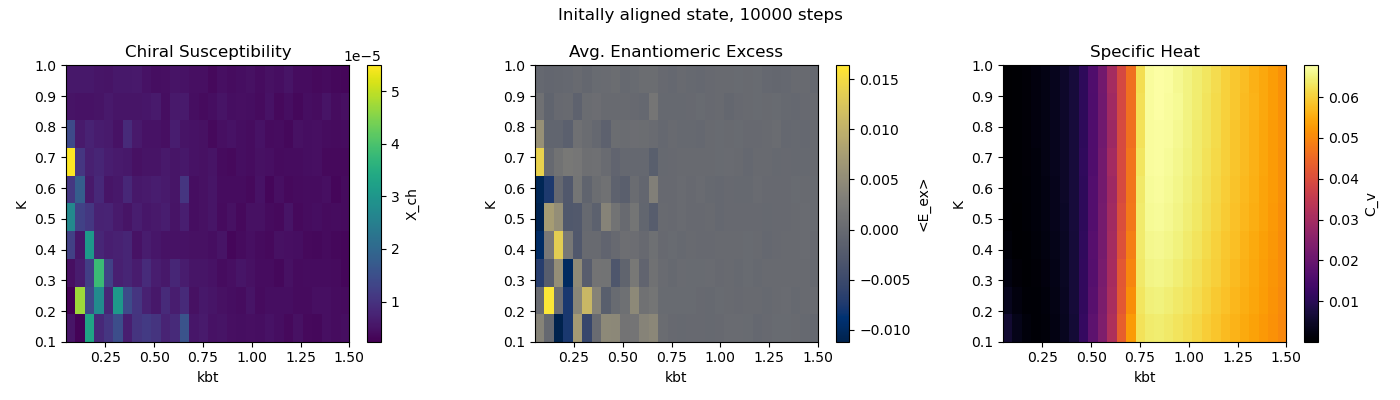

In [10]:
# 2d chiral susceptibility
# get all Ks and kbts for a range
Ks = []
kbts = []
for csvfile in csvfiles:
    csv1 = load_csv(csvfile,verbose=False)
    K = float(csvfile.split("/")[2].split("_")[-2][1:])
    kbt = float(csvfile.split("/")[2].split("_")[-1][3:])
    Ks.append(K)
    kbts.append(kbt)
    
Ks = sorted(list(set(Ks))) #list of all Ks w/ duplicates removed
Ks1 = Ks[:10] # 0.001 -> 0.01
Ks2 = Ks[9:19] # 0.01 -> 0.1
Ks3 = Ks[18:] # 0.1 -> 1.0
kbts = sorted(list(set(kbts))) # list of all Kbts w/ duplicates removed
assert len(Ks1) == len(Ks2) == len(Ks3)

def measure_chi_krange2d(krange,kbts,init_type="aligned"):
    X_ch = np.empty((len(kbts),len(Ks1)))
    avg_ent = np.empty((len(kbts),len(Ks1)))
    C_v = np.empty((len(kbts),len(Ks1)))
    print(C_v.shape)
    for csvfile in csvfiles:
        csv1 = load_csv(csvfile,verbose=False)
        K = float(csvfile.split("/")[2].split("_")[-2][1:])
        kbt = float(csvfile.split("/")[2].split("_")[-1][3:])
        if K in krange and init_type in csvfile:
            K_index = krange.index(K)
            kbt_index = kbts.index(kbt)
            # chiral susceptibility
            excess = csv1[:,2]
            X_ch[kbt_index,K_index] = np.mean(excess**2) - np.mean(excess)**2
            # average enantiomeric excess
            avg_ent[kbt_index,K_index] = np.mean(excess)
            #specific heat
            E = csv1[:,1]
            C_v[kbt_index,K_index] = (np.mean(E**2) - np.mean(E)**2)/kbt
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))
    fig.suptitle("Initally aligned state, 10000 steps")
    ax1.set_title("Chiral Susceptibility")
    ax1.set_ylabel("K")
    ax1.set_xlabel("kbt")
    im1 = ax1.imshow(X_ch.T,extent=(kbts[0],kbts[-1],krange[0],krange[-1]),aspect='auto',cmap='viridis')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('X_ch', rotation=90)
    
    ax2.set_title("Avg. Enantiomeric Excess")
    ax2.set_ylabel("K")
    ax2.set_xlabel("kbt")
    im2 = ax2.imshow(avg_ent.T,extent=(kbts[0],kbts[-1],krange[0],krange[-1]),aspect='auto',cmap='cividis')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('<E_ex>', rotation=90)
    
    ax3.set_title("Specific Heat")
    ax3.set_ylabel("K")
    ax3.set_xlabel("kbt")
    im3 = ax3.imshow(C_v.T,extent=(kbts[0],kbts[-1],krange[0],krange[-1]),aspect='auto',cmap='inferno')
    cbar3 = plt.colorbar(im3, ax=ax3)
    cbar3.set_label('C_v', rotation=90)
    fig.tight_layout()
    plt.show()
    

measure_chi_krange2d(Ks1,kbts)
measure_chi_krange2d(Ks2,kbts)
measure_chi_krange2d(Ks3,kbts)

(30, 10)


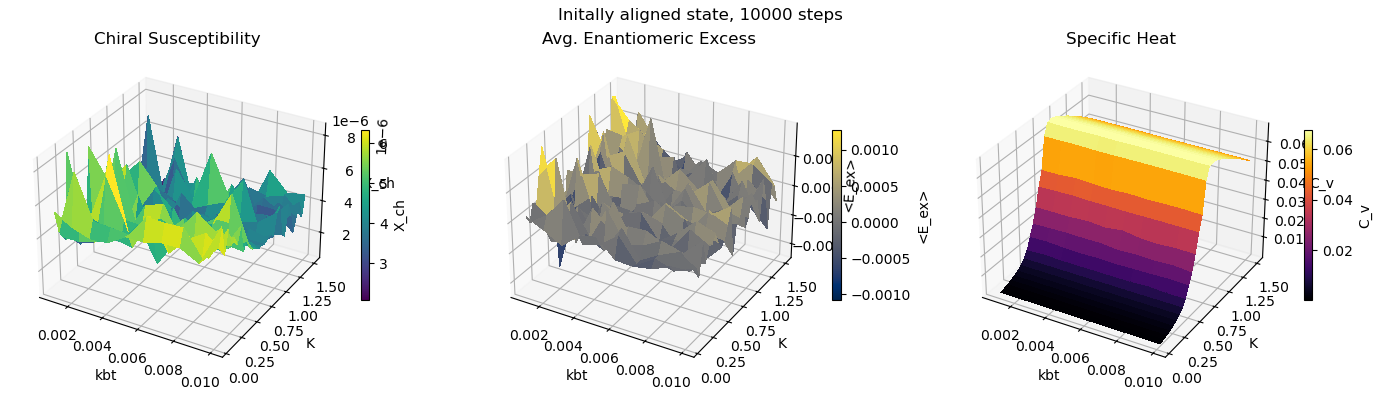

(30, 10)


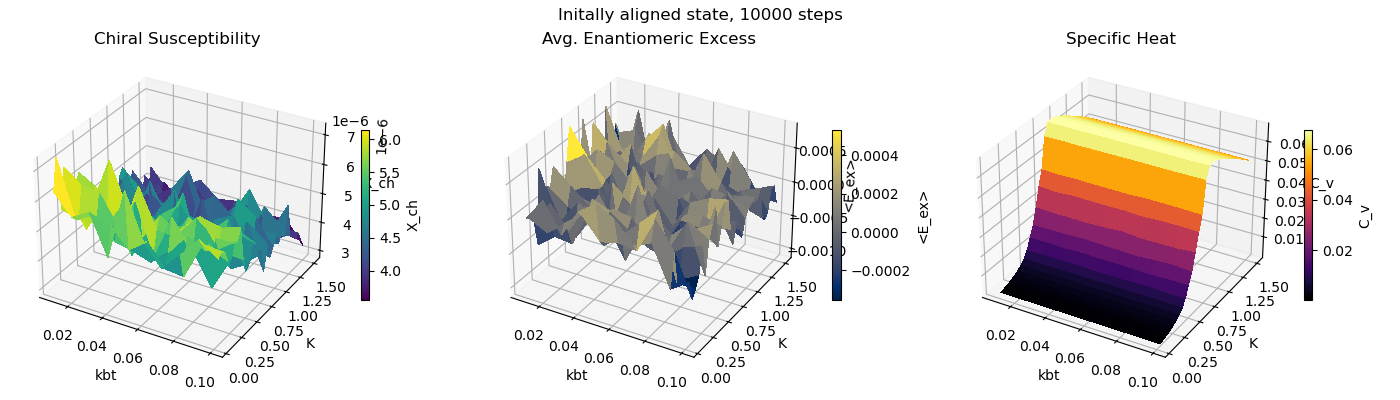

(30, 10)


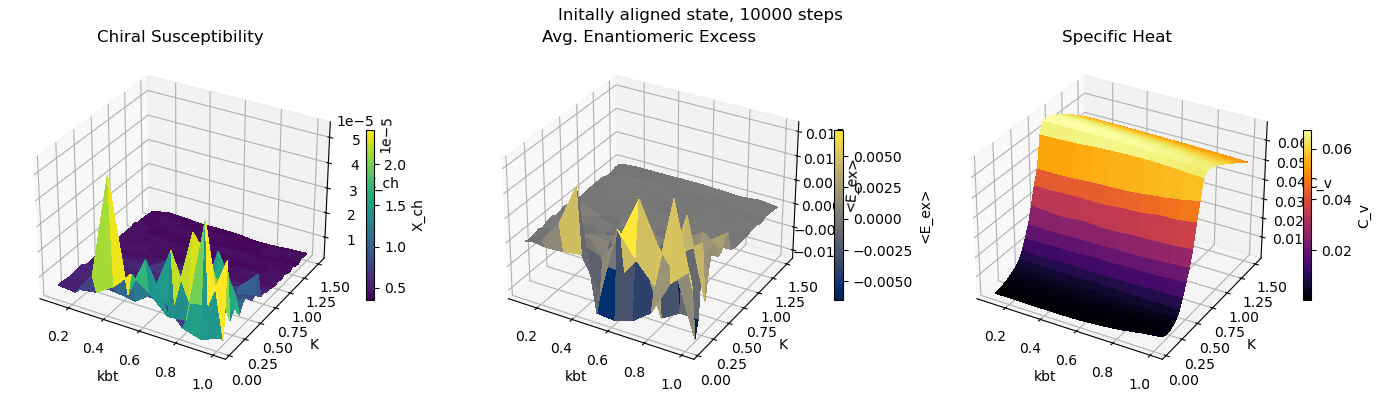

In [19]:
# 3d chiral susceptibility
# get all Ks and kbts for a range
Ks = []
kbs = []
for csvfile in csvfiles:
    csv1 = load_csv(csvfile,verbose=False)
    K = float(csvfile.split("/")[2].split("_")[-2][1:])
    kbt = float(csvfile.split("/")[2].split("_")[-1][3:])
    Ks.append(K)
    kbts.append(kbt)
    
Ks = sorted(list(set(Ks))) #list of all Ks w/ duplicates removed
Ks1 = Ks[:10] # 0.001 -> 0.01
Ks2 = Ks[9:19] # 0.01 -> 0.1
Ks3 = Ks[18:] # 0.1 -> 1.0
kbts = sorted(list(set(kbts))) # list of all Kbts w/ duplicates removed
assert len(Ks1) == len(Ks2) == len(Ks3)

def measure_chi_krange3d(krange,kbts,init_type="aligned"):
    X_ch = np.empty((len(kbts),len(Ks1)))
    avg_ent = np.empty((len(kbts),len(Ks1)))
    C_v = np.empty((len(kbts),len(Ks1)))
    print(C_v.shape)
    for csvfile in csvfiles:
        csv1 = load_csv(csvfile,verbose=False)
        K = float(csvfile.split("/")[2].split("_")[-2][1:])
        kbt = float(csvfile.split("/")[2].split("_")[-1][3:])
        if K in krange and init_type in csvfile:
            K_index = krange.index(K)
            kbt_index = kbts.index(kbt)
            # chiral susceptibility
            excess = csv1[:,2]
            X_ch[kbt_index,K_index] = np.mean(excess**2) - np.mean(excess)**2
            # average enantiomeric excess
            avg_ent[kbt_index,K_index] = np.mean(excess)
            #specific heat
            E = csv1[:,1]
            C_v[kbt_index,K_index] = (np.mean(E**2) - np.mean(E)**2)/kbt
    
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4),subplot_kw={"projection": "3d"})
    fig.suptitle("Initally aligned state, 10000 steps")
    ax1.set_title("Chiral Susceptibility")
    ax1.set_ylabel("K")
    ax1.set_xlabel("kbt")
    ax1.set_zlabel("X_ch")
    X,Y = np.meshgrid(krange,kbts)
    surf1 = ax1.plot_surface(X, Y, X_ch, cmap='viridis',linewidth=0, antialiased=False)
    cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.5)
    cbar1.set_label('X_ch', rotation=90)
    
    ax2.set_title("Avg. Enantiomeric Excess")
    ax2.set_ylabel("K")
    ax2.set_xlabel("kbt")
    ax2.set_zlabel("<E_ex>")
    X,Y = np.meshgrid(krange,kbts)
    surf2 = ax2.plot_surface(X, Y, avg_ent, cmap='cividis',linewidth=0, antialiased=False)
    cbar2 = plt.colorbar(surf2, ax=ax2,shrink=0.5)
    cbar2.set_label("<E_ex>", rotation=90)
    
    ax3.set_title("Specific Heat")
    ax3.set_ylabel("K")
    ax3.set_xlabel("kbt")
    ax3.set_zlabel("C_v")
    X,Y = np.meshgrid(krange,kbts)
    surf3 = ax3.plot_surface(X, Y, C_v, cmap='inferno',linewidth=0, antialiased=False)
    cbar3 = plt.colorbar(surf3, ax=ax3,shrink=0.5)
    cbar3.set_label('C_v', rotation=90)
    fig.tight_layout()
    plt.show()
    

measure_chi_krange3d(Ks1,kbts)
measure_chi_krange3d(Ks2,kbts)
measure_chi_krange3d(Ks3,kbts)